# Import libraries

In [ ]:
import json
import cv2
from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
import os
from PIL import Image
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import torch.nn as nn
from torchvision.models import efficientnet_b0
import torchvision.transforms as transforms
from torchvision.models import EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.hub import load_state_dict_from_url
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive
import zipfile
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


#Dataset Preparation and Visualization

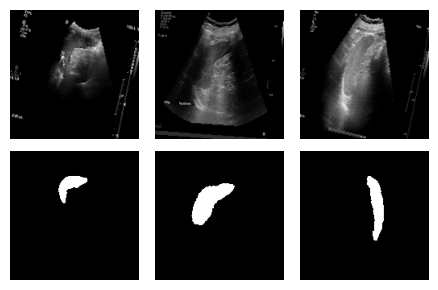

In [ ]:
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32
BATCH_SIZE_VAL = 32
img_H, img_W = 160, 160
root_dir = '/content/drive/My Drive/spleen/extracted_folder/spleen/'
model_config_dir = os.path.join(root_dir, 'config')
model_fig_dir = os.path.join(root_dir, 'fig')
data_dir = os.path.join(root_dir, 'new')
os.makedirs(data_dir, exist_ok=True)

class_idx_to_color = np.array([
    [255, 255, 255],
    [0, 0, 0]
])

class Spleen_Dataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform

        self.images_dir = os.path.join(self.data_dir, 'images')
        self.masks_dir = os.path.join(self.data_dir, 'masks')

        self.images_path = [os.path.join(self.images_dir, img_name) for img_name in sorted(os.listdir(self.images_dir))]
        self.masks_path = [os.path.join(self.masks_dir, mask_name) for mask_name in sorted(os.listdir(self.masks_dir)) if os.path.isfile(os.path.join(self.masks_dir, mask_name))]

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        img_path = self.images_path[idx]
        mask_path = self.masks_path[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        image = image.resize((img_H, img_W))
        mask = mask.resize((img_H, img_W))

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = torch.squeeze(mask, dim=0).long()

        return image, mask


train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.Resize((img_H, img_W)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((img_H, img_W)),
    transforms.ToTensor(),
])

train_ds = Spleen_Dataset(data_dir, train_transforms)
test_ds = Spleen_Dataset(data_dir, test_transforms)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE_TEST, shuffle=True)

val_transforms = transforms.Compose([
    transforms.Resize((img_H, img_W)),
    transforms.ToTensor(),
])

val_ds = Spleen_Dataset(data_dir, val_transforms)

val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE_VAL, shuffle=False)

num_samples = 3
samples_idx = np.random.choice(np.arange(len(train_ds)), num_samples, replace=False)
fig, axes = plt.subplots(2, num_samples, figsize=(1.5 * num_samples, 3))

for i, s_idx in enumerate(samples_idx):
    sample = train_ds[s_idx]
    image, mask = sample[0], sample[1]

    image = np.transpose(image.numpy(), (1, 2, 0))
    mask = np.array(mask)

    axes[0, i].imshow(image)
    axes[0, i].axis('off')

    axes[1, i].imshow(mask.squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

#Model Evaluation with Mean Intersection over Union

In [ ]:
def evaluate_model_with_mIoU(model, dataloader, device):
    """Evaluation of the model and calculate mIoU of the model"""
    model.eval()
    total_outputs = []
    total_reals = []
    total_inputs = []
    with torch.no_grad():
        running_miou = 0
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            miou = mIoU(outputs, labels)
            running_miou += miou
            total_inputs.append(inputs.detach().cpu().numpy())
            total_outputs.append(np.argmax(outputs.detach().cpu().numpy(), axis=1).squeeze())
            total_reals.append(labels.detach().cpu().numpy())
    total_miou = running_miou / len(dataloader)
    total_inputs = np.concatenate(total_inputs, axis=0)
    total_outputs = np.concatenate(total_outputs, axis=0)
    total_reals = np.concatenate(total_reals, axis=0)

    return total_miou, total_inputs, total_outputs, total_reals

#Training Progress Visualization with Loss and mIoU

In [ ]:
def plot_save_loss_miou(history, dir, model_name, save=False):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history['train_miou'], label='Training mIoU')
    plt.plot(history['val_miou'], label='Validation mIoU')
    plt.legend(loc='lower right')
    plt.ylabel('mIoU')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    plt.legend()
    if save:
        imag_dir = dir +"Metrics plot"+'/'+ model_name + '/'
        os.makedirs(imag_dir , exist_ok=True)
        plt.savefig(imag_dir+ f'train_val_acc_loss.png')
    plt.show

#Model Training and Evaluation with Loss and mIoU Tracking

In [ ]:
def train_model(model, criterion, optimizer, scheduler,dataset_sizes,dataloaders,dir, device ,  num_epochs, trained_weights= False):
    """Training the provided model with the data available through dataloader and returning (& saving) the best model achieved
    during training. Also the history of the model training (loss and accuracy for train and validation dataset) is returning """
    since = time.time()
    os.makedirs(dir , exist_ok=True)
    best_model_params_path = os.path.join(dir, 'best_model_params.pt')
    if trained_weights:
      pt_file = torch.load(best_model_params_path)
      pretrained_dict = pt_file
      model_dict = model.state_dict()
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
      model_dict.update(pretrained_dict)
      model.load_state_dict(pretrained_dict)
    else:
      torch.save(model.state_dict(), best_model_params_path)
    best_miou = 0.0
    val_losses = []
    train_losses = []
    val_mIoUs = []
    train_mIoUs = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 20)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_miou = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    miou = mIoU(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_miou += miou
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_miou = running_miou / len(dataloaders[phase])
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_mIoUs.append(epoch_miou)
                scheduler.step()
            elif phase == 'train':
                train_losses.append(epoch_loss)
                train_mIoUs.append(epoch_miou)
            lr = optimizer.state_dict()['param_groups'][0]['lr']
            print(f'{phase} Loss: {epoch_loss:.4f} mIoU: {epoch_miou:.4f} LR: { lr }')
            if phase == 'val' and epoch_miou > best_miou:
                best_miou = epoch_miou
                print("Saving best model with acc: " , best_miou)
                torch.save(model.state_dict(), best_model_params_path)
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val mIoU: {best_miou:4f}')
    model.load_state_dict(torch.load(best_model_params_path))
    history = {'train_loss' : train_losses ,'train_miou' : train_mIoUs,
               'val_loss' : val_losses ,'val_miou' : val_mIoUs,}
    return model , history

#Early Stopping Mechanism for Model Training

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

#Mean Intersection over Union (mIoU) Calculation

In [ ]:
def mIoU(pred_mask, mask, n_classes=2, smooth=1e-10):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

#U-Net Building Blocks

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

#U-Net Architecture for Semantic Segmentation

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#Training the Model

In [ ]:
EPOCHS = 100

INIT_LR = 0.0001

WEIGHT_DECAY = 0.0001

unet_model = UNet(n_channels=3, n_classes=2)
unet_model.to(device)

optimizer = optim.Adam(unet_model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)

LR_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45], gamma=0.5)

criterion = nn.CrossEntropyLoss()

unet_model, unet_history = train_model(
    unet_model, criterion, optimizer, LR_scheduler,
    dataset_sizes={'train': len(train_ds), 'val': len(val_ds)},
    dataloaders={'train': train_dataloader, 'val': val_dataloader},
    dir=os.path.join(model_config_dir, 'UNet'),
    device=device, num_epochs=EPOCHS, trained_weights=False
)

Epoch 0/99
--------------------


100%|██████████| 14/14 [06:33<00:00, 28.13s/it]


train Loss: 0.4441 mIoU: 0.5503 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.5548 mIoU: 0.4790 LR: 0.0001
Saving best model with acc:  0.478974302009343

Epoch 1/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


train Loss: 0.3321 mIoU: 0.6466 LR: 0.0001


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.4602 mIoU: 0.4741 LR: 0.0001

Epoch 2/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.2763 mIoU: 0.6779 LR: 0.0001


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.3130 mIoU: 0.4763 LR: 0.0001

Epoch 3/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.2419 mIoU: 0.6709 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.2388 mIoU: 0.6854 LR: 0.0001
Saving best model with acc:  0.6854046133657069

Epoch 4/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.2234 mIoU: 0.6718 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.2067 mIoU: 0.7536 LR: 0.0001
Saving best model with acc:  0.7535660660464165

Epoch 5/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


train Loss: 0.2140 mIoU: 0.6673 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.1973 mIoU: 0.8080 LR: 0.0001
Saving best model with acc:  0.8080392098926443

Epoch 6/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


train Loss: 0.2016 mIoU: 0.6700 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.1767 mIoU: 0.8421 LR: 0.0001
Saving best model with acc:  0.8420831067591487

Epoch 7/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.1905 mIoU: 0.6873 LR: 0.0001


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.1674 mIoU: 0.7812 LR: 0.0001

Epoch 8/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


train Loss: 0.1857 mIoU: 0.6743 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.1547 mIoU: 0.8341 LR: 0.0001

Epoch 9/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1856 mIoU: 0.6748 LR: 0.0001


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.1693 mIoU: 0.7424 LR: 0.0001

Epoch 10/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


train Loss: 0.1763 mIoU: 0.6822 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.1528 mIoU: 0.8082 LR: 0.0001

Epoch 11/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


train Loss: 0.1679 mIoU: 0.6972 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.48s/it]


val Loss: 0.1401 mIoU: 0.8127 LR: 0.0001

Epoch 12/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.1646 mIoU: 0.6924 LR: 0.0001


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.1386 mIoU: 0.8161 LR: 0.0001

Epoch 13/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1605 mIoU: 0.6901 LR: 0.0001


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.1348 mIoU: 0.8257 LR: 0.0001

Epoch 14/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1632 mIoU: 0.6905 LR: 0.0001


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.1731 mIoU: 0.5161 LR: 5e-05

Epoch 15/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


train Loss: 0.1623 mIoU: 0.6805 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


val Loss: 0.1425 mIoU: 0.8253 LR: 5e-05

Epoch 16/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


train Loss: 0.1540 mIoU: 0.7012 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.47s/it]


val Loss: 0.1303 mIoU: 0.8504 LR: 5e-05
Saving best model with acc:  0.8504271293912808

Epoch 17/99
--------------------


100%|██████████| 14/14 [00:27<00:00,  1.96s/it]


train Loss: 0.1548 mIoU: 0.6786 LR: 5e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.1276 mIoU: 0.7846 LR: 5e-05

Epoch 18/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1500 mIoU: 0.6891 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


val Loss: 0.1204 mIoU: 0.8602 LR: 5e-05
Saving best model with acc:  0.8602162857236731

Epoch 19/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


train Loss: 0.1486 mIoU: 0.6901 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


val Loss: 0.1250 mIoU: 0.8341 LR: 5e-05

Epoch 20/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1444 mIoU: 0.7006 LR: 5e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.1203 mIoU: 0.8254 LR: 5e-05

Epoch 21/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1403 mIoU: 0.7146 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


val Loss: 0.1130 mIoU: 0.8711 LR: 5e-05
Saving best model with acc:  0.871087657589599

Epoch 22/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


train Loss: 0.1401 mIoU: 0.7021 LR: 5e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.1129 mIoU: 0.8348 LR: 5e-05

Epoch 23/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.92s/it]


train Loss: 0.1376 mIoU: 0.7107 LR: 5e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.1116 mIoU: 0.8574 LR: 5e-05

Epoch 24/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1378 mIoU: 0.7055 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.1117 mIoU: 0.8576 LR: 5e-05

Epoch 25/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1368 mIoU: 0.7003 LR: 5e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.1149 mIoU: 0.8448 LR: 5e-05

Epoch 26/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1337 mIoU: 0.7091 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.1064 mIoU: 0.8737 LR: 5e-05
Saving best model with acc:  0.8737168519129721

Epoch 27/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


train Loss: 0.1323 mIoU: 0.7105 LR: 5e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.1095 mIoU: 0.8328 LR: 5e-05

Epoch 28/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.1311 mIoU: 0.7097 LR: 5e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.1046 mIoU: 0.8785 LR: 5e-05
Saving best model with acc:  0.8785398347453824

Epoch 29/99
--------------------


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


train Loss: 0.1299 mIoU: 0.7056 LR: 5e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.1013 mIoU: 0.8577 LR: 2.5e-05

Epoch 30/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1287 mIoU: 0.7112 LR: 2.5e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.1060 mIoU: 0.8422 LR: 2.5e-05

Epoch 31/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1249 mIoU: 0.7215 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.1006 mIoU: 0.8739 LR: 2.5e-05

Epoch 32/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1255 mIoU: 0.7175 LR: 2.5e-05


100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


val Loss: 0.1073 mIoU: 0.8143 LR: 2.5e-05

Epoch 33/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1252 mIoU: 0.7142 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0997 mIoU: 0.8795 LR: 2.5e-05
Saving best model with acc:  0.8795116307771772

Epoch 34/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.1220 mIoU: 0.7354 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


val Loss: 0.0980 mIoU: 0.8796 LR: 2.5e-05
Saving best model with acc:  0.879566230478862

Epoch 35/99
--------------------


100%|██████████| 14/14 [00:27<00:00,  1.95s/it]


train Loss: 0.1241 mIoU: 0.7183 LR: 2.5e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.1018 mIoU: 0.8571 LR: 2.5e-05

Epoch 36/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1213 mIoU: 0.7267 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0932 mIoU: 0.8865 LR: 2.5e-05
Saving best model with acc:  0.886487204220657

Epoch 37/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.1195 mIoU: 0.7342 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0986 mIoU: 0.8653 LR: 2.5e-05

Epoch 38/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1235 mIoU: 0.7100 LR: 2.5e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.1032 mIoU: 0.8329 LR: 2.5e-05

Epoch 39/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1232 mIoU: 0.7063 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.1024 mIoU: 0.8666 LR: 2.5e-05

Epoch 40/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.82s/it]


train Loss: 0.1205 mIoU: 0.7175 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0970 mIoU: 0.8769 LR: 2.5e-05

Epoch 41/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.86s/it]


train Loss: 0.1178 mIoU: 0.7287 LR: 2.5e-05


100%|██████████| 14/14 [00:19<00:00,  1.43s/it]


val Loss: 0.0962 mIoU: 0.8774 LR: 2.5e-05

Epoch 42/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1182 mIoU: 0.7231 LR: 2.5e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.0935 mIoU: 0.8552 LR: 2.5e-05

Epoch 43/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1173 mIoU: 0.7311 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0952 mIoU: 0.8697 LR: 2.5e-05

Epoch 44/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1165 mIoU: 0.7330 LR: 2.5e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.0933 mIoU: 0.8705 LR: 1.25e-05

Epoch 45/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1161 mIoU: 0.7285 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


val Loss: 0.0933 mIoU: 0.8690 LR: 1.25e-05

Epoch 46/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1147 mIoU: 0.7340 LR: 1.25e-05


100%|██████████| 14/14 [00:21<00:00,  1.52s/it]


val Loss: 0.0922 mIoU: 0.8736 LR: 1.25e-05

Epoch 47/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1155 mIoU: 0.7262 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0967 mIoU: 0.8525 LR: 1.25e-05

Epoch 48/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1176 mIoU: 0.7146 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.0967 mIoU: 0.8601 LR: 1.25e-05

Epoch 49/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1155 mIoU: 0.7246 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0908 mIoU: 0.8867 LR: 1.25e-05
Saving best model with acc:  0.8867491026664045

Epoch 50/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


train Loss: 0.1132 mIoU: 0.7349 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


val Loss: 0.0901 mIoU: 0.8824 LR: 1.25e-05

Epoch 51/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1155 mIoU: 0.7243 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.0925 mIoU: 0.8838 LR: 1.25e-05

Epoch 52/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


train Loss: 0.1166 mIoU: 0.7116 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.0936 mIoU: 0.8713 LR: 1.25e-05

Epoch 53/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


train Loss: 0.1129 mIoU: 0.7341 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0903 mIoU: 0.8809 LR: 1.25e-05

Epoch 54/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1135 mIoU: 0.7323 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0919 mIoU: 0.8806 LR: 1.25e-05

Epoch 55/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1148 mIoU: 0.7150 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.0917 mIoU: 0.8839 LR: 1.25e-05

Epoch 56/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.86s/it]


train Loss: 0.1103 mIoU: 0.7468 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.0871 mIoU: 0.9005 LR: 1.25e-05
Saving best model with acc:  0.9004631060664902

Epoch 57/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.1126 mIoU: 0.7299 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.0912 mIoU: 0.8650 LR: 1.25e-05

Epoch 58/99
--------------------


100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


train Loss: 0.1105 mIoU: 0.7380 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.0868 mIoU: 0.8905 LR: 1.25e-05

Epoch 59/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


train Loss: 0.1119 mIoU: 0.7293 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0897 mIoU: 0.8831 LR: 1.25e-05

Epoch 60/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1130 mIoU: 0.7196 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.0916 mIoU: 0.8601 LR: 1.25e-05

Epoch 61/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1094 mIoU: 0.7365 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.0869 mIoU: 0.8906 LR: 1.25e-05

Epoch 62/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1130 mIoU: 0.7190 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


val Loss: 0.0934 mIoU: 0.8478 LR: 1.25e-05

Epoch 63/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1107 mIoU: 0.7286 LR: 1.25e-05


100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


val Loss: 0.0868 mIoU: 0.8869 LR: 1.25e-05

Epoch 64/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


train Loss: 0.1099 mIoU: 0.7290 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.0879 mIoU: 0.8858 LR: 1.25e-05

Epoch 65/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.88s/it]


train Loss: 0.1092 mIoU: 0.7388 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.0856 mIoU: 0.8927 LR: 1.25e-05

Epoch 66/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.86s/it]


train Loss: 0.1103 mIoU: 0.7299 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.0862 mIoU: 0.8858 LR: 1.25e-05

Epoch 67/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1105 mIoU: 0.7258 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


val Loss: 0.0881 mIoU: 0.8779 LR: 1.25e-05

Epoch 68/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1090 mIoU: 0.7310 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.44s/it]


val Loss: 0.0878 mIoU: 0.8846 LR: 1.25e-05

Epoch 69/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.91s/it]


train Loss: 0.1064 mIoU: 0.7444 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.0826 mIoU: 0.9008 LR: 1.25e-05
Saving best model with acc:  0.9008185094812865

Epoch 70/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


train Loss: 0.1078 mIoU: 0.7405 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.43s/it]


val Loss: 0.0844 mIoU: 0.8956 LR: 1.25e-05

Epoch 71/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1089 mIoU: 0.7289 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.0875 mIoU: 0.8611 LR: 1.25e-05

Epoch 72/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


train Loss: 0.1075 mIoU: 0.7380 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.0837 mIoU: 0.8948 LR: 1.25e-05

Epoch 73/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1086 mIoU: 0.7279 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0871 mIoU: 0.8686 LR: 1.25e-05

Epoch 74/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1080 mIoU: 0.7282 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.45s/it]


val Loss: 0.0851 mIoU: 0.8926 LR: 1.25e-05

Epoch 75/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1084 mIoU: 0.7215 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.0869 mIoU: 0.8772 LR: 1.25e-05

Epoch 76/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.85s/it]


train Loss: 0.1055 mIoU: 0.7470 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.0831 mIoU: 0.8911 LR: 1.25e-05

Epoch 77/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1050 mIoU: 0.7439 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0821 mIoU: 0.8872 LR: 1.25e-05

Epoch 78/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1070 mIoU: 0.7286 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.0856 mIoU: 0.8791 LR: 1.25e-05

Epoch 79/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1054 mIoU: 0.7363 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.0823 mIoU: 0.8891 LR: 1.25e-05

Epoch 80/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


train Loss: 0.1066 mIoU: 0.7322 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0825 mIoU: 0.8930 LR: 1.25e-05

Epoch 81/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.82s/it]


train Loss: 0.1080 mIoU: 0.7168 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.0854 mIoU: 0.8830 LR: 1.25e-05

Epoch 82/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1041 mIoU: 0.7396 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.42s/it]


val Loss: 0.0813 mIoU: 0.9037 LR: 1.25e-05
Saving best model with acc:  0.9036572498347258

Epoch 83/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


train Loss: 0.1056 mIoU: 0.7333 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


val Loss: 0.0831 mIoU: 0.8726 LR: 1.25e-05

Epoch 84/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.82s/it]


train Loss: 0.1049 mIoU: 0.7334 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.0835 mIoU: 0.8902 LR: 1.25e-05

Epoch 85/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1039 mIoU: 0.7381 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.50s/it]


val Loss: 0.0800 mIoU: 0.8983 LR: 1.25e-05

Epoch 86/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1040 mIoU: 0.7339 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.39s/it]


val Loss: 0.0802 mIoU: 0.8828 LR: 1.25e-05

Epoch 87/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1031 mIoU: 0.7450 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.43s/it]


val Loss: 0.0816 mIoU: 0.8794 LR: 1.25e-05

Epoch 88/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1048 mIoU: 0.7268 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.36s/it]


val Loss: 0.0823 mIoU: 0.8932 LR: 1.25e-05

Epoch 89/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1033 mIoU: 0.7380 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0804 mIoU: 0.8891 LR: 1.25e-05

Epoch 90/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1044 mIoU: 0.7307 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


val Loss: 0.0803 mIoU: 0.9011 LR: 1.25e-05

Epoch 91/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


train Loss: 0.1016 mIoU: 0.7425 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.43s/it]


val Loss: 0.0770 mIoU: 0.9087 LR: 1.25e-05
Saving best model with acc:  0.9087138105458786

Epoch 92/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1024 mIoU: 0.7358 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.37s/it]


val Loss: 0.0780 mIoU: 0.9011 LR: 1.25e-05

Epoch 93/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1037 mIoU: 0.7324 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.43s/it]


val Loss: 0.0781 mIoU: 0.8858 LR: 1.25e-05

Epoch 94/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1020 mIoU: 0.7377 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


val Loss: 0.0794 mIoU: 0.8985 LR: 1.25e-05

Epoch 95/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


train Loss: 0.1047 mIoU: 0.7186 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


val Loss: 0.0818 mIoU: 0.8796 LR: 1.25e-05

Epoch 96/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.84s/it]


train Loss: 0.1020 mIoU: 0.7345 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


val Loss: 0.0794 mIoU: 0.9028 LR: 1.25e-05

Epoch 97/99
--------------------


100%|██████████| 14/14 [00:25<00:00,  1.83s/it]


train Loss: 0.1016 mIoU: 0.7362 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.43s/it]


val Loss: 0.0790 mIoU: 0.9009 LR: 1.25e-05

Epoch 98/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1009 mIoU: 0.7371 LR: 1.25e-05


100%|██████████| 14/14 [00:20<00:00,  1.46s/it]


val Loss: 0.0773 mIoU: 0.8890 LR: 1.25e-05

Epoch 99/99
--------------------


100%|██████████| 14/14 [00:26<00:00,  1.87s/it]


train Loss: 0.1017 mIoU: 0.7298 LR: 1.25e-05


100%|██████████| 14/14 [00:19<00:00,  1.41s/it]


val Loss: 0.0799 mIoU: 0.8857 LR: 1.25e-05

Training complete in 83m 19s
Best val mIoU: 0.908714


#Plotting and Saving Loss and mIoU Metrics for The Model

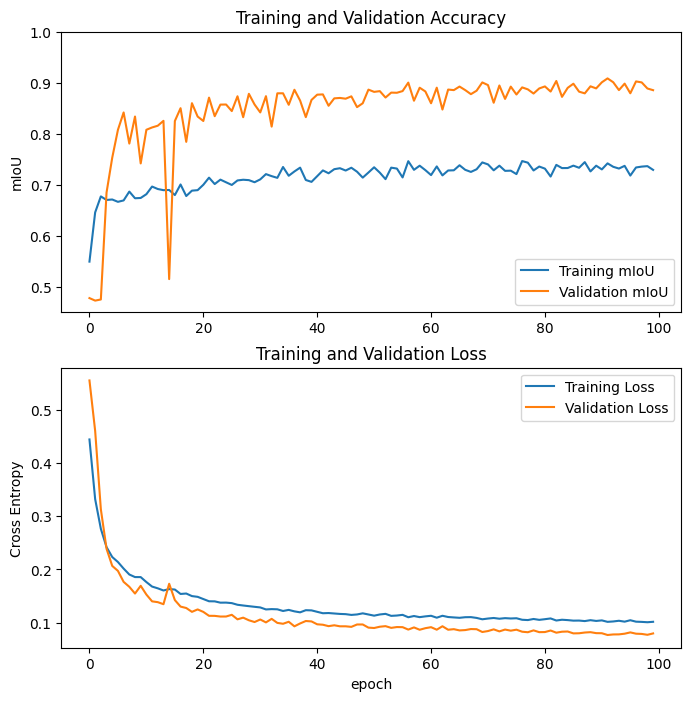

In [ ]:
plot_save_loss_miou(unet_history, dir=model_fig_dir, model_name=None, save=False)

#Evaluation of the Model Performance on Test Set

In [ ]:
test_miou, _, _, _ = evaluate_model_with_mIoU(unet_model, test_dataloader, device)

print(f'Test mIoU: {test_miou:.4f}')

100%|██████████| 14/14 [00:30<00:00,  2.16s/it]

Test mIoU: 0.9094


#Visualization of UNet Model Predictions on Train and Test Samples

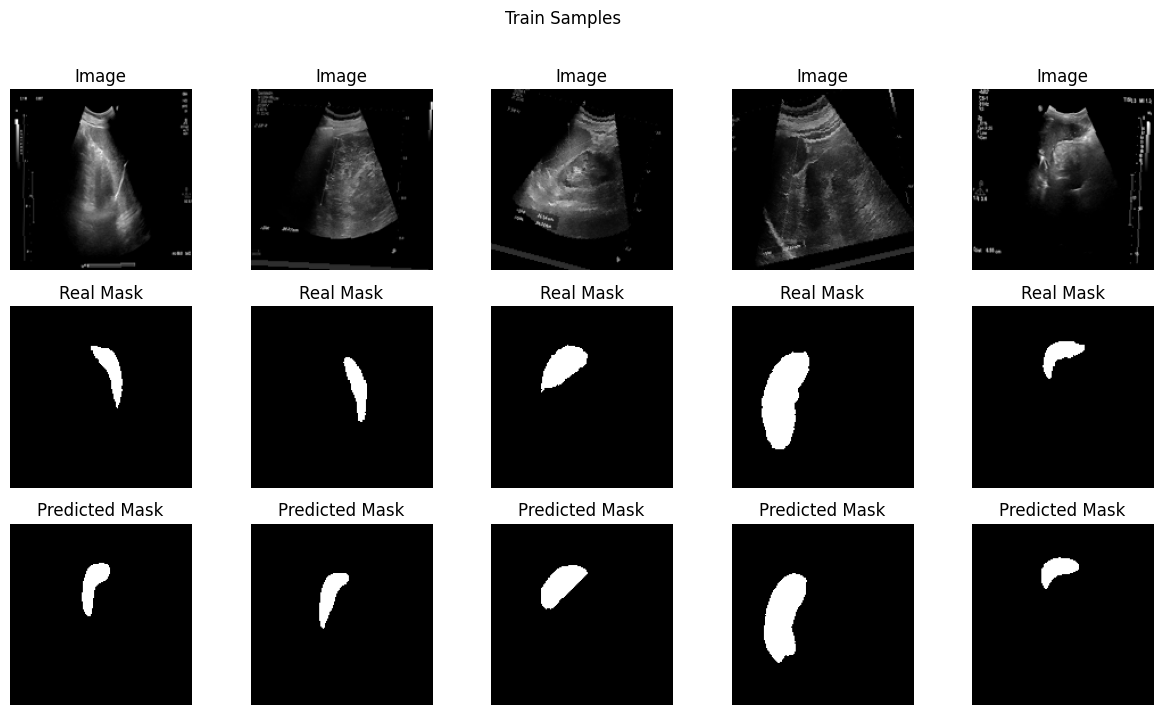

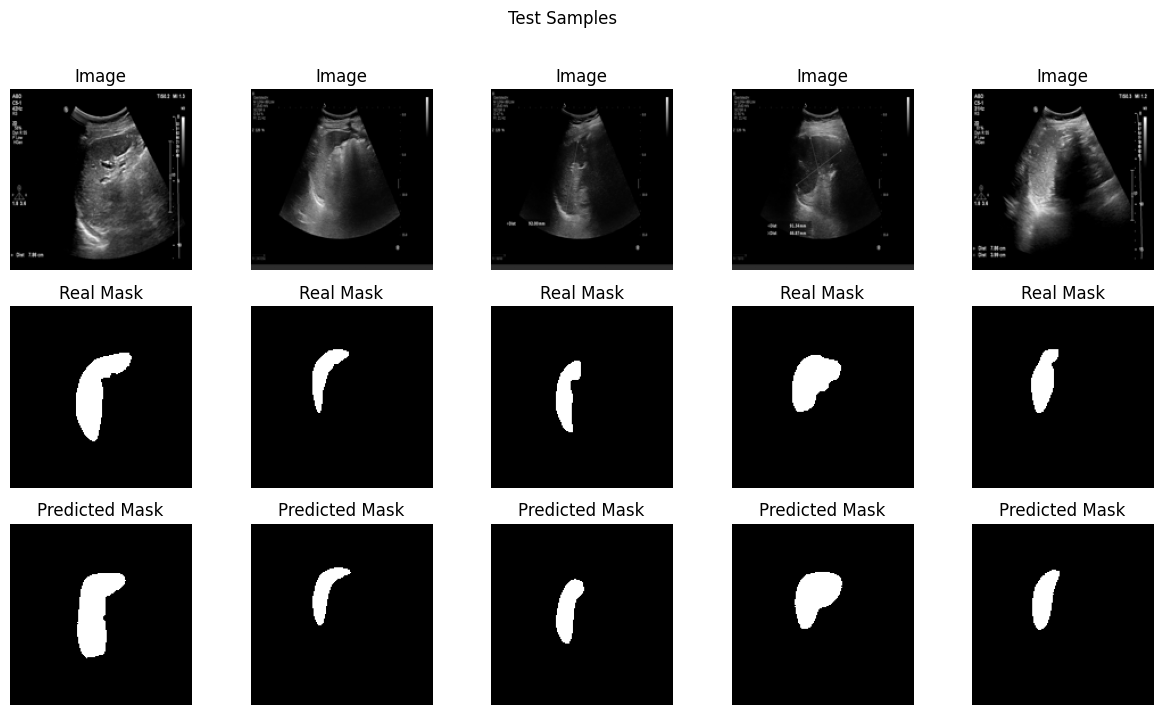

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet(n_channels=3, n_classes=2)
unet_model.load_state_dict(torch.load(os.path.join(model_config_dir, 'UNet', 'best_model_params.pt')))
unet_model.eval()
unet_model.to(device)

train_samples_idx = np.random.choice(np.arange(len(train_ds)), 5, replace=False)
train_samples = [train_ds[i] for i in train_samples_idx]

test_samples_idx = np.random.choice(np.arange(len(test_ds)), 5, replace=False)
test_samples = [test_ds[i] for i in test_samples_idx]

def plot_samples(samples, title):
    fig, axes = plt.subplots(3, len(samples), figsize=(15, 8))
    for i, (image, mask) in enumerate(samples):
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = unet_model(image_tensor)
            predicted_mask = torch.argmax(output, dim=1).cpu().numpy().squeeze()

        axes[0, i].imshow(np.transpose(image.numpy(), (1, 2, 0)))
        axes[0, i].set_title("Image")
        axes[0, i].axis("off")

        axes[1, i].imshow(mask.squeeze(), cmap='gray')
        axes[1, i].set_title("Real Mask")
        axes[1, i].axis("off")

        axes[2, i].imshow(predicted_mask, cmap='gray')
        axes[2, i].set_title("Predicted Mask")
        axes[2, i].axis("off")

    plt.suptitle(title)
    plt.show()

plot_samples(train_samples, "Train Samples")

plot_samples(test_samples, "Test Samples")

In [ ]:
model_save_path = '/content/drive/My Drive/spleen/'

torch.save(unet_model, model_save_path)

print(f'Entire model saved to {model_save_path}')

Entire model saved to /content/drive/My Drive/spleen/extracted_folder/spleen/trained_model.pth
